# Preparation 
## Append to path and import
In case gumpy is not installed as package, you may have to specify the path to the gumpy directory

In [1]:
%reset
%matplotlib inline

import sys, os, os.path
sys.path.append('../../../gumpy')

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## import gumpy
This may take a while, as gumpy as several dependencies that will be loaded automatically

In [2]:
import numpy as np
import gumpy

# Import data
To import data, you have to specify the directory in which your data is stored in. For the example given here, the data is in the subfolder ``../EEG-Data/Graz_data/data``. 
Then, one of the classes that subclass from ``dataset`` can be used to load the data. In the example, we will use the GrazB dataset, for which ``gumpy`` already includes a corresponding class. If you have different data, simply subclass from ``gumpy.dataset.Dataset``.

In [3]:
# First specify the location of the data and some 
# identifier that is exposed by the dataset (e.g. subject)

data_base_dir = '../../../Data'

grazb_base_dir = os.path.join(data_base_dir, 'Graz')
subject = 'B01'

# The next line first initializes the data structure. 
# Note that this does not yet load the data! In custom implementations
# of a dataset, this should be used to prepare file transfers, 
# for instance check if all files are available, etc.
grazb_data = gumpy.data.GrazB(grazb_base_dir, subject)

# Finally, load the dataset
grazb_data.load()

The abstract class allows to print some information about the contained data. This is a commodity function that allows quick inspection of the data as long as all necessary fields are provided in the subclassed variant.

In [4]:
grazb_data.print_stats()

Data identification: GrazB-B01
EEG-data shape: (1626266, 3)
Trials data shape:  (324,)
Labels shape:  (324,)
Total length of single trial:  8
Sampling frequency of EEG data: 250
Interval for motor imagery in trial:  [4, 7]
Classes possible:  [0 1]


# Postprocess data
Usually it is necessary to postprocess the raw data before you can properly use it. ``gumpy`` provides several methods to easily do so, or provides implementations that can be adapted to your needs.

Most methods internally use other Python toolkits, for instance ``sklearn``, which is heavily used throughout ``gumpy``. Thereby, it is easy to extend ``gumpy`` with custom filters. In addition, we expect users to have to manipulate the raw data directly as shown in the following example.

## Common average re-referencing the data  to Cz
Some data is required to be re-referenced to a certain electrode. Because this may depend on your dataset, there is no common function provided by ``gumpy`` to do so. However and if sub-classed according to the documentation, you can access the raw-data directly as in the following example.

In [5]:
if 0:
    grazb_data.raw_data[:, 0] -= 2 * grazb_data.raw_data[:, 1]
    grazb_data.raw_data[:, 2] -= 2 * grazb_data.raw_data[:, 2]

## Example: Notch and Band-Pass Filters
``gumpy`` ships with several filters already implemented. They accept either raw data to be filtered, or a subclass of ``Dataset``. In the latter case, ``gumpy`` will automatically convert all channels using parameters extracted from the dataset.

In [6]:
# this returns a butter-bandpass filtered version of the entire dataset
btr_data = gumpy.signal.butter_bandpass(grazb_data, lo=2, hi=60)

# it is also possible to use filters on individual electrodes using 
# the .raw_data field of a dataset. The example here will remove a certain
# from a single electrode using a Notch filter. This example also demonstrates
# that parameters will be forwarded to the internal call to the filter, in this
# case the scipy implementation iirnotch (Note that iirnotch is only available
# in recent versions of scipy, and thus disabled in this example by default)

# frequency to be removed from the signal
if False:
    f0 = 50.0 
    # quality factor
    Q = 50.0  
    # get the cutoff frequency
    w0 = f0/(grazb_data.sampling_freq/2) 
    # apply the notch filter
    btr_data = gumpy.signal.notch(btr_data.raw_data[:, 0], w0, Q)

## Normalization
Many datasets require normalization. ``gumpy`` provides functions to compute normalization either using a mean computation or via min/max computation. As with the filters, this function accepts either an instance of ``Dataset``, or raw_data. In fact, it can be used for postprocessing any row-wise data in a numpy matrix.

In [7]:
# normalize the data first
norm_data = gumpy.signal.normalize(btr_data, 'mean_std')
# let's see some statistics
print("""Normalized Data:
  Mean    = {:.3f}
  Min     = {:.3f}
  Max     = {:.3f}
  Std.Dev = {:.3f}""".format(
  np.nanmean(norm_data),np.nanmin(norm_data),np.nanmax(norm_data),np.nanstd(norm_data)
))

Normalized Data:
  Mean    = -0.000
  Min     = -21.830
  Max     = 14.876
  Std.Dev = 1.000


# Plotting and Feature Extraction

Certainly you wish to plot results. ``gumpy`` provides several functions that show how to implement visualizations. For this purpose it heavily relies on ``matplotlib``, ``pandas``, and ``seaborn``. The following examples will show several of the implemented signal processing methods as well as their corresponding plotting functions. Moreover, the examples will show you how to extract features

That said, let's start with a simple visualization where we access the filtered data from above to show you how to access the data and plot it.

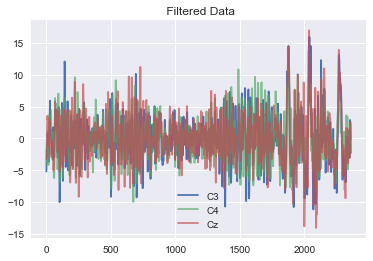

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt 

# Plot after filtering with a butter bandpass (ignore normalization)
plt.figure()
plt.clf()
plt.plot(btr_data[grazb_data.trials[0]: grazb_data.trials[1], 0], label='C3')
plt.plot(btr_data[grazb_data.trials[0]: grazb_data.trials[1], 1], alpha=0.7, label='C4')
plt.plot(btr_data[grazb_data.trials[0]: grazb_data.trials[1], 2], alpha=0.7, label='Cz')
plt.legend()
plt.title(" Filtered Data")

## EEG band visualization
Using ``gumpy``'s filters and the provided method, it is easy to filter and subsequently plot the  EEG bands of a trial.

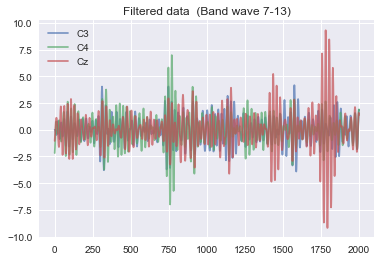

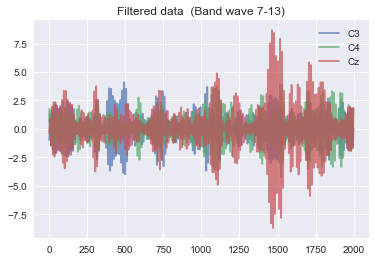

In [9]:
# determine the trial that we wish to plot
n_trial = 120
# now specify the alpha and beta cutoff frequencies
lo_a, lo_b = 7, 16
hi_a, hi_b = 13, 24

# first step is to filter the data
flt_a = gumpy.signal.butter_bandpass(grazb_data, lo=lo_a, hi=hi_a)
flt_b = gumpy.signal.butter_bandpass(grazb_data, lo=lo_b, hi=hi_b)

# finally we can visualize the data
gumpy.plot.EEG_bandwave_visualizer(grazb_data, flt_a, n_trial, lo_a, hi_a)
gumpy.plot.EEG_bandwave_visualizer(grazb_data, flt_b, n_trial, lo_a, hi_a)

## Extract trials
Now we wish to extract the trials from the data. This operation may heavily depend on your dataset, and thus we cannot guarantee that the function works for your specific dataset. However, the used function ``gumpy.utils.extract_trials`` can be used as a guideline how to extract the trials you wish to examine.

In [10]:
# retrieve the trials from the filtered data. This requires that the function
# knows the number of trials, labels, etc. when only passed a (filtered) data matrix
trials = grazb_data.trials
labels = grazb_data.labels
sampling_freq = grazb_data.sampling_freq
data_class_a = gumpy.utils.extract_trials(flt_a, trials=trials, labels=labels, sampling_freq=sampling_freq)

# it is also possible to pass an instance of Dataset and filtered data.
# gumpy will then infer all necessary details from the dataset
data_class_b = gumpy.utils.extract_trials(grazb_data, flt_b)

# similar to other functions, this one allows to pass an entire instance of Dataset
# to operate on the raw data
data_class1 = gumpy.utils.extract_trials(grazb_data)

## Visualize the classes
Given the extracted trials from above, we can proceed to visualize the average power of a class. Again, this depends on the specific data and thus you may have to adapt the function accordingly.

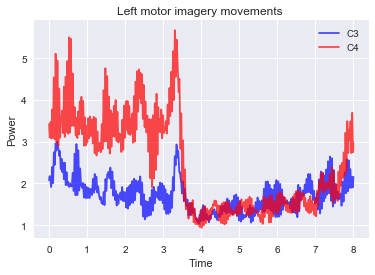

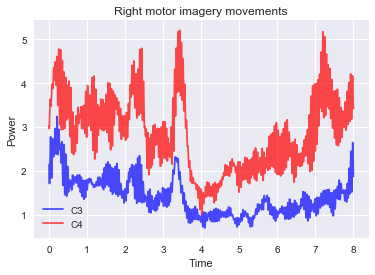

In [11]:
# specify some cutoff values for the visualization
lowcut_a, highcut_a = 14, 30
# and also an interval to display
interval_a = [0, 8]
# visualize logarithmic power?
logarithmic_power = False

# visualize the extracted trial from above
gumpy.plot.average_power(data_class_a, lowcut_a, highcut_a, interval_a, grazb_data.sampling_freq, logarithmic_power)

## Wavelet transform
``gumpy`` relies on ``pywt`` to compute wavelet transforms. Furthermore, it contains convenience functions to visualize the results of the discrete wavelet transform as shown in the example below for the Graz dataset and the classes extracted above.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ae0455b38>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f5ae03f7668>], dtype=object)

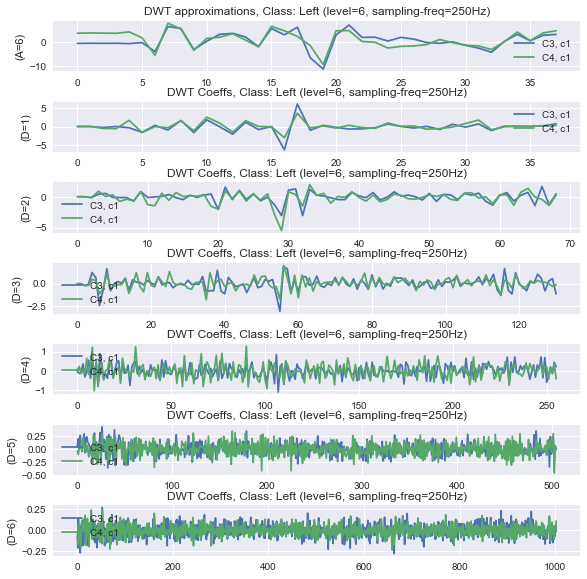

In [12]:
# As with most functions, you can pass arguments to a 
# gumpy function that will be forwarded to the backend.
# In this example the decomposition levels are mandatory, and the 
# mother wavelet that should be passed is optional
level = 6
wavelet = 'db4'

# now we can retrieve the dwt for the different channels
mean_coeff_ch0_c1 = gumpy.signal.dwt(data_class1[0], level=level, wavelet=wavelet)
mean_coeff_ch1_c1 = gumpy.signal.dwt(data_class1[1], level=level, wavelet=wavelet)
mean_coeff_ch0_c2 = gumpy.signal.dwt(data_class1[3], level=level, wavelet=wavelet)
mean_coeff_ch1_c2 = gumpy.signal.dwt(data_class1[4], level=level, wavelet=wavelet)

# gumpy's signal.dwt function returns the approximation of the 
# coefficients as first result, and all the coefficient details as list
# as second return value (this is contrast to the backend, which returns
# the entire set of coefficients as a single list)
approximation_C3 = mean_coeff_ch0_c2[0]
approximation_C4 = mean_coeff_ch1_c2[0]

# as mentioned in the comment above, the list of details are in the second
# return value of gumpy.signal.dwt. Here we save them to additional variables
# to improve clarity
details_c3_c1 = mean_coeff_ch0_c1[1]
details_c4_c1 = mean_coeff_ch1_c1[1]
details_c3_c2 = mean_coeff_ch0_c2[1]
details_c4_c2 = mean_coeff_ch1_c2[1]

# gumpy exhibits a function to plot the dwt results. You must pass three lists,
# i.e. the labels of the data, the approximations, as well as the detailed coeffs,
# so that gumpy can automatically generate appropriate titles and labels.
# you can pass an additional class string that will be incorporated into the title.
# the function returns a matplotlib axis object in case you want to further
# customize the plot.
gumpy.plot.dwt(
    [approximation_C3, approximation_C4],
    [details_c3_c1, details_c4_c1],
    ['C3, c1', 'C4, c1'],
    level, grazb_data.sampling_freq, 'Class: Left')


## DWT reconstruction and visualization
Often a user wantes to reconstruct the power spectrum of a dwt and visualize the results. The functions will return a list of all the reconstructed signals as well as a handle to the figure.

([array([  5.21503658e-07,   1.61819012e-06,   3.04630780e-06, ...,
           3.08312365e-12,   1.59095105e-12,  -5.12725164e-13]),
  array([  1.43090770e-07,   4.44000857e-07,   8.35849420e-07, ...,
          -2.05427255e-11,  -1.06004411e-11,   3.41626658e-12])],
 <matplotlib.figure.Figure at 0x7f5ae047f3c8>)

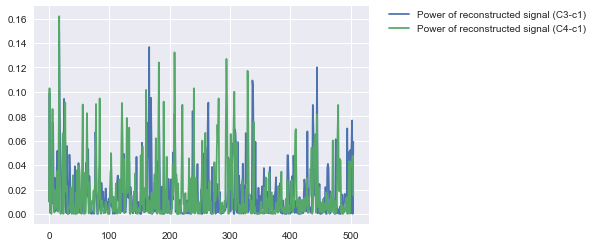

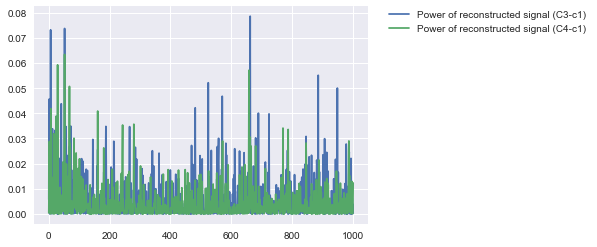

In [13]:
gumpy.plot.reconstruct_without_approx(
    [details_c3_c2[4], details_c4_c2[4]], 
    ['C3-c1', 'C4-c1'], level=6)

gumpy.plot.reconstruct_without_approx(
    [details_c3_c1[5], details_c4_c1[5]], 
    ['C3-c1', 'C4-c1'], level=6)

([array([-0.04379641,  0.17916636, -0.15634663, ...,  0.05339261,
         -0.05486782,  0.01305731]),
  array([-0.01783179,  0.0415965 , -0.07318729, ...,  0.03480512,
         -0.01006542,  0.00087816])],
 <matplotlib.figure.Figure at 0x7f5ae052b710>)

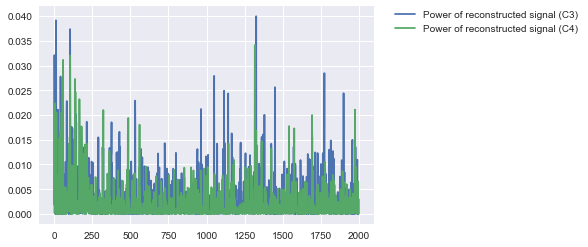

In [14]:
gumpy.plot.reconstruct_with_approx(
    [details_c3_c1[5], details_c4_c1[5]],
    ['C3', 'C4'], wavelet=wavelet)

## Welch's Power Spectral Density estimate
Estimating the power spectral density according to Welch's method is =imilar to the power reconstruction shown above

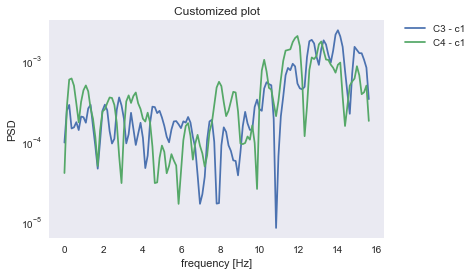

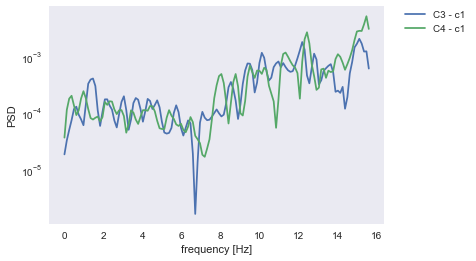

In [15]:
# the function gumpy.plot.welch_psd returns the power densities as 
# well as a handle to the figure. You can also pass a figure in if you 
# wish to modify the plot
fig = plt.figure()
plt.title('Customized plot')
ps, fig = gumpy.plot.welch_psd(
    [details_c3_c1[4], details_c3_c2[4]],
    ['C3 - c1', 'C4 - c1'],
    grazb_data.sampling_freq, fig=fig)

ps, fig = gumpy.plot.welch_psd(
    [details_c4_c1[4], details_c4_c2[4]],
    ['C3 - c1', 'C4 - c1'],
    grazb_data.sampling_freq)

## Alpha and Beta sub-bands
Using gumpys functions you can quickly define feature extractors. The following examples will demonstrate how you can use the predefined filters

In [16]:
def alpha_subBP_features(data):
    # filter data in sub-bands by specification of low- and high-cut frequencies
    alpha1 = gumpy.signal.butter_bandpass(data, 8.5, 11.5, order=6)
    alpha2 = gumpy.signal.butter_bandpass(data, 9.0, 12.5, order=6)
    alpha3 = gumpy.signal.butter_bandpass(data, 9.5, 11.5, order=6)
    alpha4 = gumpy.signal.butter_bandpass(data, 8.0, 10.5, order=6)

    # return a list of sub-bands
    return [alpha1, alpha2, alpha3, alpha4]

alpha_bands = np.array(alpha_subBP_features(grazb_data))

In [17]:
def beta_subBP_features(data):
    beta1 = gumpy.signal.butter_bandpass(data, 14.0, 30.0, order=6)
    beta2 = gumpy.signal.butter_bandpass(data, 16.0, 17.0, order=6)
    beta3 = gumpy.signal.butter_bandpass(data, 17.0, 18.0, order=6)
    beta4 = gumpy.signal.butter_bandpass(data, 18.0, 19.0, order=6)
    return [beta1, beta2, beta3, beta4]

beta_bands = np.array(beta_subBP_features(grazb_data))

## Feature extraction using sub-bands
The following examples show how the sub-bands can be used to extract features. This also shows how the fields of the dataset can be accessed, and how to write methods specific to your data using a mix of gumpy's and numpy's functions.

### Method 1: logarithmic sub-band power

In [18]:
def powermean(data, trial, fs, w):
    return np.power(data[trial+fs*4+w[0]: trial+fs*4+w[1],0],2).mean(), \
           np.power(data[trial+fs*4+w[0]: trial+fs*4+w[1],1],2).mean(), \
           np.power(data[trial+fs*4+w[0]: trial+fs*4+w[1],2],2).mean()

def log_subBP_feature_extraction(alpha, beta, trials, fs, w):
    # number of features combined for all trials
    n_features = 15
    # initialize the feature matrix
    X = np.zeros((len(trials), n_features))
    
    # Extract features
    for t, trial in enumerate(trials):
        power_c31, power_c41, power_cz1 = powermean(alpha[0], trial, fs, w)
        power_c32, power_c42, power_cz2 = powermean(alpha[1], trial, fs, w)
        power_c33, power_c43, power_cz3 = powermean(alpha[2], trial, fs, w)
        power_c34, power_c44, power_cz4 = powermean(alpha[3], trial, fs, w)
        power_c31_b, power_c41_b, power_cz1_b = powermean(beta[0], trial, fs, w)
        
        X[t, :] = np.array(
            [np.log(power_c31), np.log(power_c41), np.log(power_cz1),
             np.log(power_c32), np.log(power_c42), np.log(power_cz2),
             np.log(power_c33), np.log(power_c43), np.log(power_cz3), 
             np.log(power_c34), np.log(power_c44), np.log(power_cz4),
             np.log(power_c31_b), np.log(power_c41_b), np.log(power_cz1_b)])

    return X

In [19]:
w1 = [0,125]
w2 = [125,250]

features1 = log_subBP_feature_extraction(
    alpha_bands, beta_bands, 
    grazb_data.trials, grazb_data.sampling_freq,
    w1)

features2 = log_subBP_feature_extraction(
    alpha_bands, beta_bands, 
    grazb_data.trials, grazb_data.sampling_freq,
    w2)                                          

# concatenate the features and normalize the data
features = np.concatenate((features1.T, features2.T)).T
features -= np.mean(features)
features = gumpy.signal.normalize(features, 'min_max')

# print shape to quickly check if everything is as expected
features.shape

(324, 30)

### Method 2: DWT

In [20]:
def dwt_features(data, trials, level, sampling_freq, w, n, wavelet): 
    import pywt
    
    # number of features per trial
    n_features = 9 
    # allocate memory to store the features
    X = np.zeros((len(trials), n_features))

    # Extract Features
    for t, trial in enumerate(trials):
        signals = data[trial + fs*4 + (w[0]) : trial + fs*4 + (w[1])]
        coeffs_c3 = pywt.wavedec(data = signals[:,0], wavelet=wavelet, level=level)
        coeffs_c4 = pywt.wavedec(data = signals[:,1], wavelet=wavelet, level=level)
        coeffs_cz = pywt.wavedec(data = signals[:,2], wavelet=wavelet, level=level)

        X[t, :] = np.array([
            np.std(coeffs_c3[n]), np.mean(coeffs_c3[n]**2),  
            np.std(coeffs_c4[n]), np.mean(coeffs_c4[n]**2),
            np.std(coeffs_cz[n]), np.mean(coeffs_cz[n]**2), 
            np.mean(coeffs_c3[n]),
            np.mean(coeffs_c4[n]), 
            np.mean(coeffs_cz[n])])
        
    return X

In [21]:
# We'll work with the data that was postprocessed using a butter bandpass
# filter further above

# to see it work, enable here. We'll use the log-power features further
# below, though
if False:
    w = [0, 256]
    
    # extract the features
    trials = grazb_data.trials
    fs = grazb_data.sampling_freq
    features1= np.array(dwt_features(btr_data, trials, 5, fs, w, 3, "db4"))
    features2= np.array(dwt_features(btr_data, trials, 5, fs, w, 4, "db4"))

    # concat the features and normalize
    features = np.concatenate((features1.T, features2.T)).T
    features -= np.mean(features)
    features = gumpy.signal.normalize(features, 'min_max')

## Sequential Feature Selection Algorithm
``gumpy`` provides a generic function with which you can select features. For a list of the implemented selectors please have a look at the function documentation.


[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished

[2018-02-16 13:50:59] Features: 1/12 -- score: 0.597021627566[Parallel(n_jobs=-1)]: Done   7 out of  29 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2018-02-16 13:50:59] Features: 2/12 -- score: 0.627703445748[Parallel(n_jobs=-1)]: Done   6 out of  28 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2018-02-16 13:51:00] Features: 3/12 -- score: 0.66718597263[Parallel(n_jobs=-1)]: Done   6 out of  27 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s fin

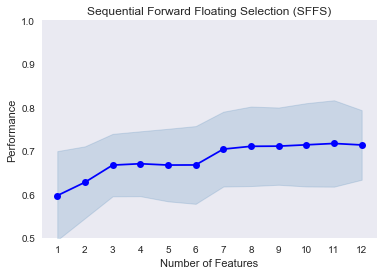

In [22]:
feature_idx, cv_scores, algorithm = gumpy.features.sequential_feature_selector(features, labels, 'LDA', (6, 12), 10, 'SFFS')

In [23]:
# let's see some information about the results
print('Selection Algorithm: ', algorithm)
print('Average Score:       ', cv_scores * 100)
print('Feature Index:       ', feature_idx)

Selection Algorithm:  Sequential Forward Floating Selection (SFFS)
Average Score:        71.6920210166
Feature Index:        (4, 6, 8, 11, 12, 13, 14, 23, 26, 28, 29)


## PCA 
``gumpy`` provides a wrapper around sklearn to reduce the dimensionality via PCA in a straightfoward manner.

In [24]:
PCA = gumpy.features.PCA_dim_red(features, 0.95)

## Splitting data for training and classification
Now that we extracted features (and reduced the dimensionality), we can split the data for 
test and training purposes.

In [25]:
test_size = 0.2

# gumpy exposes several methods to split a dataset, as shown in the examples:
if 1: 
    split_features = np.array(gumpy.split.normal(features, labels,test_size))
if 0: 
    n_splits=5
    split_features = np.array(gumpy.split.time_series_split(features, labels, n_splits)) 
if 0: 
    split_features = np.array(gumpy.split.normal(PCA, labels, test_size))

# the functions return a list with the data according to the following example
X_train = split_features[0]
X_test = split_features[1]
Y_train = split_features[2]
Y_test = split_features[3]

X_train.shape

(259, 30)

## Plotting features
``gumpy`` wraps 3D plotting of features into a single line

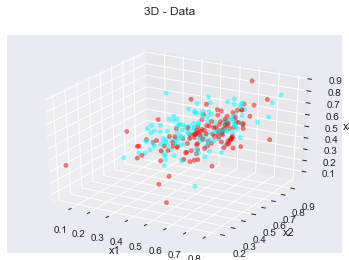

In [26]:
gumpy.plot.PCA("3D", features, split_features[0], split_features[2])

## Classification with normal split

In [27]:
results, clf = gumpy.classify('LDA', X_train, Y_train, X_test, Y_test)

In [28]:
print("Classification results on test set:")
print(results)
print("Accuracy: ", results.accuracy)

Classification results on test set:
             precision    recall  f1-score   support

          0       0.73      0.63      0.68        38
          1       0.56      0.67      0.61        27

avg / total       0.66      0.65      0.65        65

Accuracy:  64.61538461538461


## Confusion Matrix
One of the ideas behind ``gumpy`` is to provide users the means to quickly examine their data. Therefore, gumpy provides mostly wraps existing libraries. This allows to show data with ease, and still be able to modify the plots in any way the underlying libraries allow:

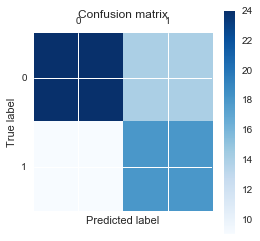

In [29]:
gumpy.plot.confusion_matrix(Y_test, results.pred)

## Voting Classifier with feature selection
`gumpy` allows to automatically use all classifiers that are known in `gumpy.classification.available_classifiers` in a voting classifier (for more details see `sklearn.ensemble.VotingClassifier`). In case you developed a custom classifier and registered it using the `@register_classifier` decorator, it will be automatically used as well.

In [30]:
result, _ = gumpy.classification.vote(X_train, Y_train, X_test, Y_test, 'hard', False, (6,12))
print("Classification result for hard voting classifier")
print(result)
print("Accuracy: ", result.accuracy)

Classification result for hard voting classifier
             precision    recall  f1-score   support

          0       0.73      0.63      0.68        38
          1       0.56      0.67      0.61        27

avg / total       0.66      0.65      0.65        65

Accuracy:  64.61538461538461


Again, we can plot the confusion matrix to have a look at the results

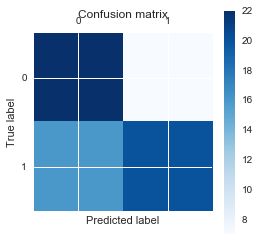

In [31]:
gumpy.plot.confusion_matrix(result.pred, Y_test)

Because `gumpy.classification.vote` uses `sklearn.ensemble.VotingClassifier` as backend, it is possible to specify different methods for the voting such as 'soft'. In addition, the method can be told to first extract features via `mlxtend.feature_selection.SequentialFeatureSelector` before classification.

In [32]:
result, _ = gumpy.classification.vote(X_train, Y_train, X_test, Y_test, 'soft', True, (6,12))
print("Classification result for soft voting classifier")
print(result)
print("Accuracy: ", result.accuracy)

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   35.8s finished

[2018-02-16 13:51:47] Features: 1/12 -- score: 0.598324786325[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   39.5s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.1s finished

[2018-02-16 13:52:31] Features: 2/12 -- score: 0.663897435897[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   35.9s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.0s finished

[2018-02-16 13:53:12] Features: 3/12 -- score: 0.66758974359[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   35.8s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s finished

[2018-02-16 13:53:53] Features: 4/12 -- score: 0.651908831909[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:   35.8s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    5.3s finished

[2018-02-16 13:54:35] Features: 5/12 -- score: 0.660512820513[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed

Classification result for soft voting classifier
             precision    recall  f1-score   support

          0       0.73      0.63      0.68        38
          1       0.56      0.67      0.61        27

avg / total       0.66      0.65      0.65        65

Accuracy:  64.61538461538461


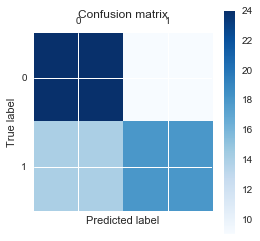

In [33]:
gumpy.plot.confusion_matrix(result.pred, Y_test)